# 1. Import Ntuple

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import uproot
from tqdm.auto import tqdm
import sys
sys.path.append('/home/belle/zhangboy/inclusive_R_D/')
import utilities as util

training_variables = util.training_variables
columns = util.all_relevant_variables

Welcome to JupyROOT 6.26/14


In [2]:
# 4S Data vs MC

cut = '(5<B0_roeMbc_my_mask) & (-4<B0_roeDeltae_my_mask) & (B0_roeDeltae_my_mask<1)'

# Load data files
MC_4S = uproot.concatenate([f'../../Samples/Generic_MC15ri/e_channel/MC15ri_1ab_quaxo_e_2/*.root:B0'],
                          library="np",
                          cut = cut,
                          filter_branch=lambda branch: branch.name in columns)

data_4S = uproot.concatenate([f'../../Samples/Data/e_channel/proc13_4S_quaxo_4.root:B0'],
                          library="np",
                          cut = cut,
                          filter_branch=lambda branch: branch.name in columns)

df_mc_4S = pd.DataFrame(MC_4S)
df_data_4S = pd.DataFrame(data_4S)

In [3]:
lgb_tight = 'sig_prob==largest_prob and sig_prob>0.65 and fakeD_prob<0.05'
ag_tight = 'sig_prob==largest_prob and sig_prob>0.8 and fakeD_prob<0.05'
MVA_all = 'D_M>0'

for df in [df_mc_4S,df_data_4S]:
    # df.eval(f'cos_D_l = (D_px*ell_px + D_py*ell_py + D_pz*ell_pz)/(D_p*ell_p)', inplace=True)
    df.eval('B_D_ReChi2 = B0_vtxReChi2 + D_vtxReChi2', inplace=True)
    df.eval('p_D_l = D_CMS_p + ell_CMS_p', inplace=True)

df_mc_4S_lgb = util.apply_mva_bcs(df_mc_4S, training_variables, lgb_tight, library='lgbm')
df_data_4S_lgb = util.apply_mva_bcs(df_data_4S, training_variables, lgb_tight, library='lgbm')

In [11]:
columns_without_nan = df_data_4S_lgb.columns[~df_data_4S_lgb.isna().any()].tolist()

samples=util.get_dataframe_samples_new(df_mc_4S_lgb, 'e', template=False)
mpl=util.mpl(samples,df_data_4S_lgb)
# df_conti_conti = samples['bkg_continuum']
for name, df in samples.items():
    print(name, len(df))

bkg_fakeD 47187
bkg_TDFl 6338
bkg_fakeTracks 2637
bkg_continuum 13203
bkg_combinatorial 15124
bkg_singleBbkg 9611
bkg_other_TDTl 0
$D\tau\nu$ 4241
$D^\ast\tau\nu$ 2483
$D\ell\nu$ 90282
$D^\ast\ell\nu$ 57810
$D^{\ast\ast}\tau\nu$ 1472
$D^{\ast\ast}\ell\nu$_narrow 18373
$D^{\ast\ast}\ell\nu$_broad 14110
$D\ell\nu$_gap_pi 3467
$D\ell\nu$_gap_eta 3076
bkg_other_signal 0


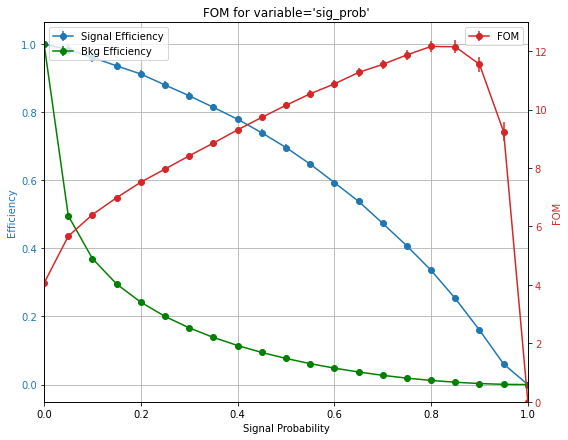

In [19]:
# lgbm
tests = np.linspace(0,1,21)
mpl.plot_FOM(sigModes=[r'$D\tau\nu$'],bkgModes=['bkg_fakeD','bkg_TDFl','bkg_fakeTracks',
                                                'bkg_continuum','bkg_combinatorial','bkg_singleBbkg'],
            variable='sig_prob', test_points=tests)

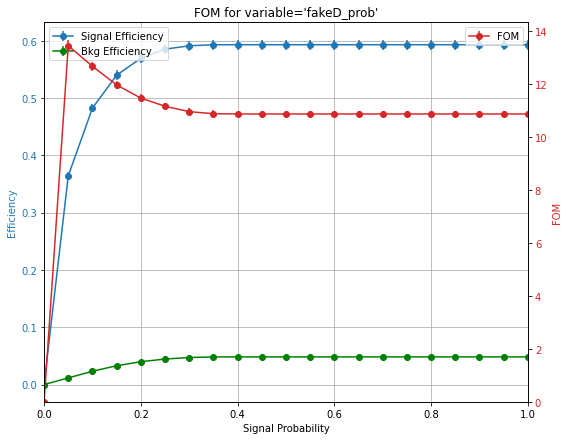

In [20]:
# lightgbm
tests = np.linspace(0,1,21)
mpl.plot_FOM(sigModes=[r'$D\tau\nu$'],bkgModes=['bkg_fakeD','bkg_TDFl','bkg_fakeTracks',
                                                'bkg_continuum','bkg_combinatorial','bkg_singleBbkg'],
            variable='fakeD_prob', test_points=tests, cut='sig_prob>0.6',reverse=True)

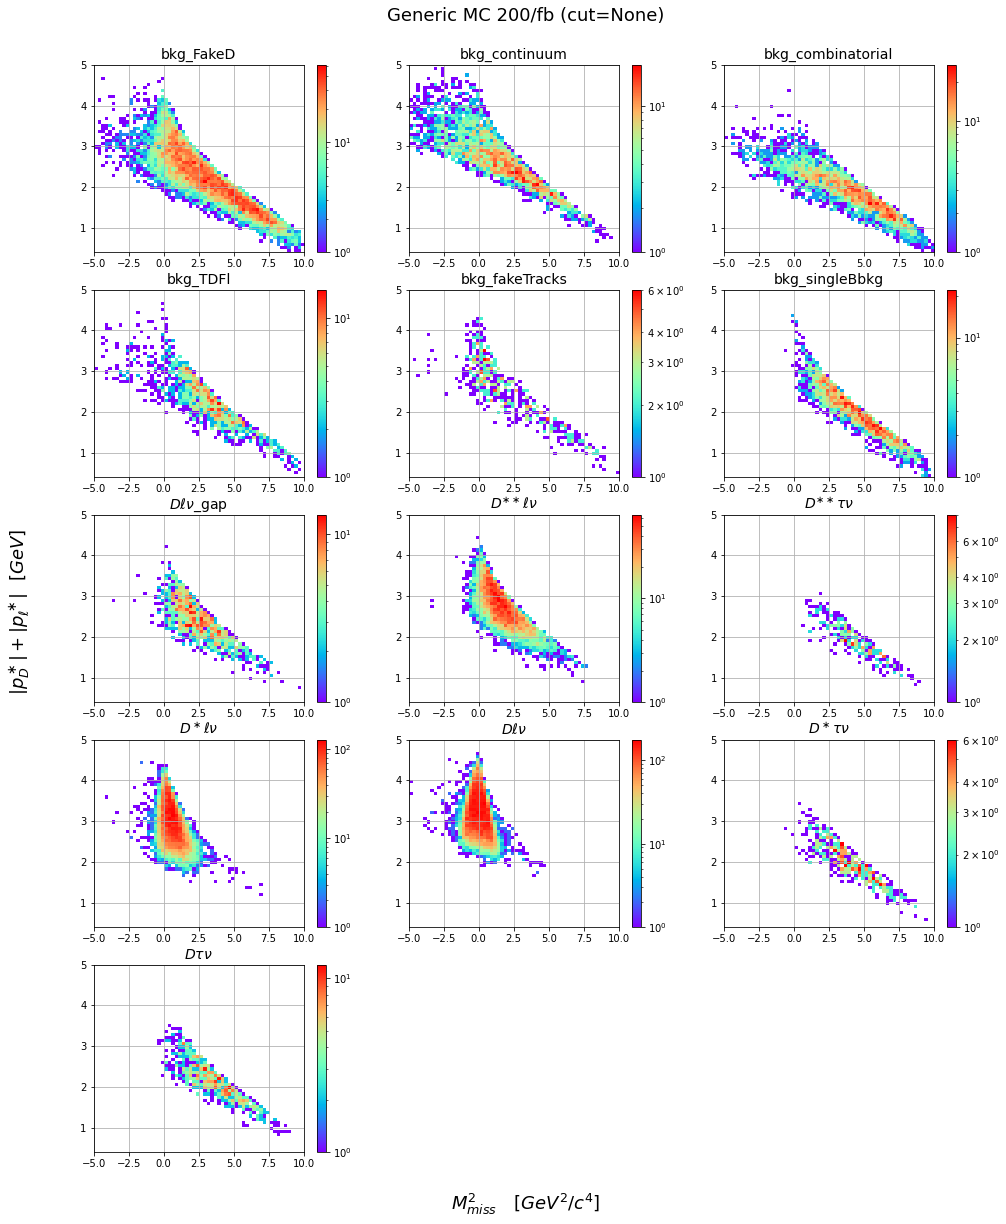

In [15]:
# Define the fitting range and number of bins, 'p_D_l'
start = 0.4
end = 5
num_bins = 60

# Create the bin edges
p_D_l_bins = np.linspace(start, end, num_bins + 1)

# Define the fitting range and number of bins, 'B0_CMS3_weMissM2'
start = -5
end = 10
num_bins = 60

# Create the bin edges
MM2_bins = np.linspace(start, end, num_bins + 1)

mpl.plot_all_2Dhist(bin_list=[MM2_bins,p_D_l_bins], mask=None)

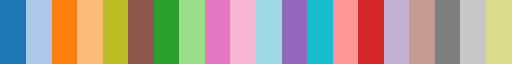

In [10]:
util.my_cmap

# SIG distribution at M_D signal region

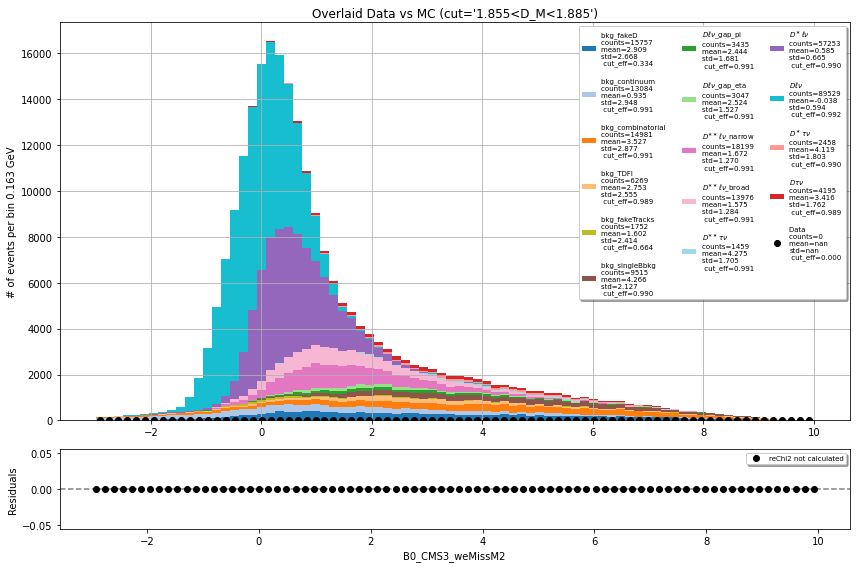

In [7]:
b1 = np.linspace(-3,10,81)
data_hist_all, mc_hist_all = mpl.plot_data_mc_stacked(
    variable='B0_CMS3_weMissM2',bins=b1,cut='1.855<D_M<1.885',scale=[1,187/200],density=False,
    correction=False,mask=[],figsize=(12,8),ratio=False,data_sig_mask=True,
                                legend_nc=3, legend_fs=7)

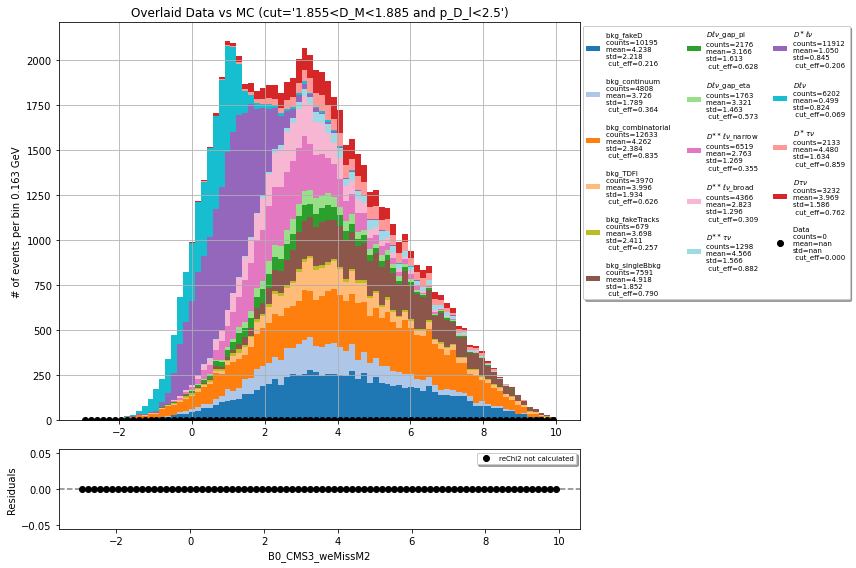

In [13]:
b1 = np.linspace(-3,10,81)
data_hist_all, mc_hist_all = mpl.plot_data_mc_stacked(
    variable='B0_CMS3_weMissM2',bins=b1,cut='1.855<D_M<1.885 and p_D_l<2.5',scale=[1,187/200],density=False,
    correction=False,mask=[],figsize=(12,8),ratio=False,data_sig_mask=True,
                                legend_nc=3, legend_fs=7)

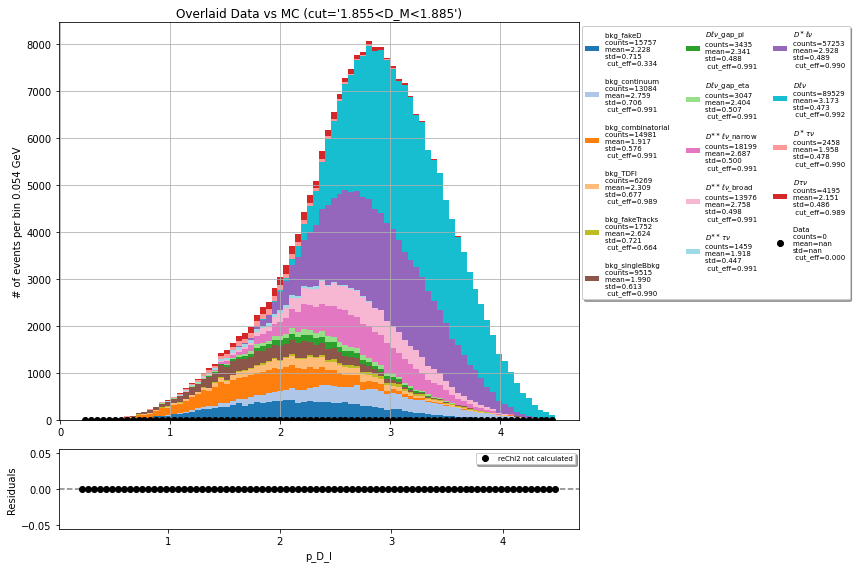

In [14]:
b1 = np.linspace(0.2,4.5,81)
data_hist_all, mc_hist_all = mpl.plot_data_mc_stacked(
    variable='p_D_l',bins=b1,cut='1.855<D_M<1.885',scale=[1,187/200],density=False,
    correction=False,mask=[],figsize=(12,8),ratio=False,data_sig_mask=True,
                                legend_nc=3, legend_fs=7)

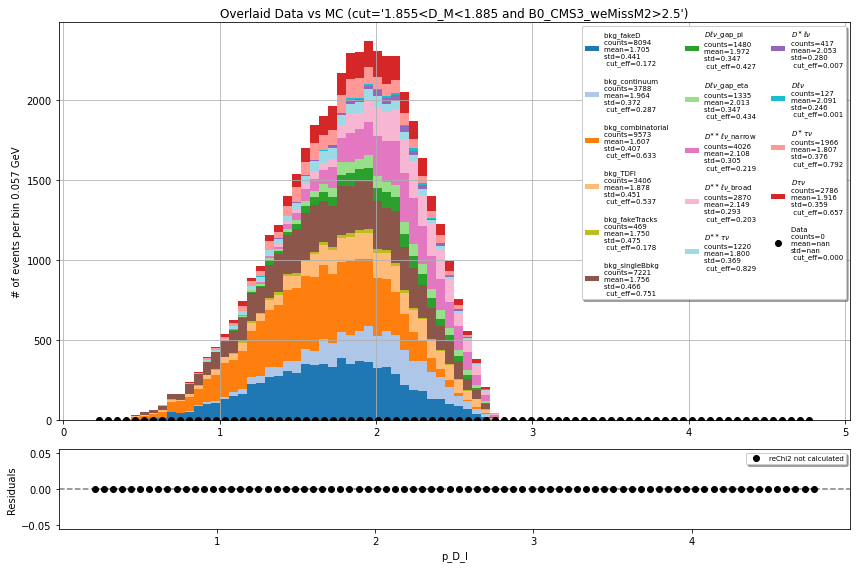

In [15]:
b1 = np.linspace(0.2,4.8,81)
data_hist_all, mc_hist_all = mpl.plot_data_mc_stacked(
    variable='p_D_l',bins=b1,cut='1.855<D_M<1.885 and B0_CMS3_weMissM2>2.5',scale=[1,187/200],density=False,
    correction=False,mask=[],figsize=(12,8),ratio=False,data_sig_mask=True,
                                legend_nc=3, legend_fs=7)

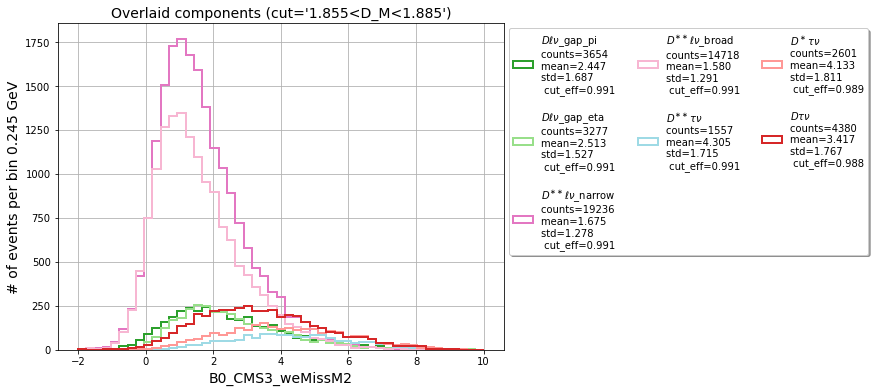

In [6]:
b1 = np.linspace(-2,10,51)
mpl.plot_mc_1d_overlaid(variable='B0_CMS3_weMissM2',bins=b1,mask=[],
                        cut='1.855<D_M<1.885',
                        show_only='sig',density=False)

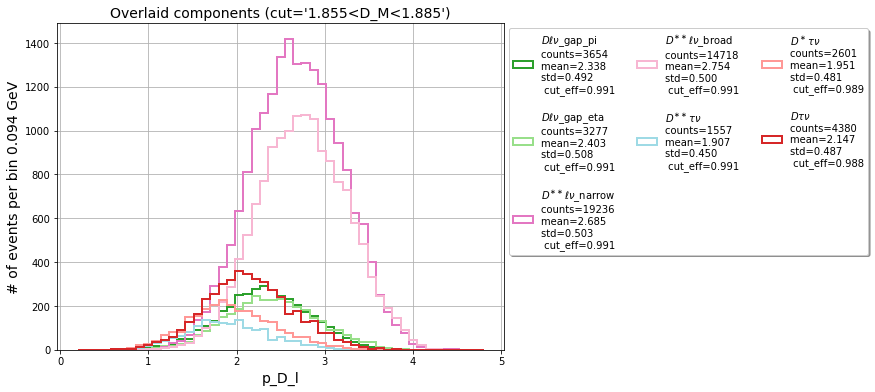

In [8]:
b1 = np.linspace(0.2,4.8,51)
mpl.plot_mc_1d_overlaid(variable='p_D_l',bins=b1,mask=[],
                        cut='1.855<D_M<1.885',
                        show_only='sig',density=False)

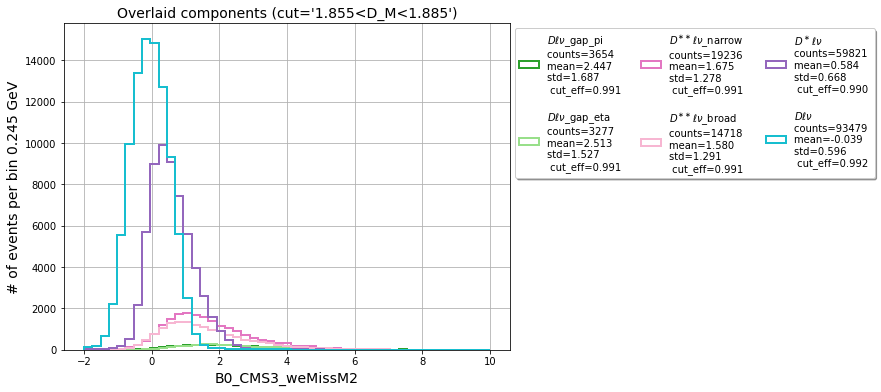

In [7]:
b1 = np.linspace(-2,10,51)
mpl.plot_mc_1d_overlaid(variable='B0_CMS3_weMissM2',bins=b1,
                        cut='1.855<D_M<1.885',mask=[],
                        show_only='norm',density=False)

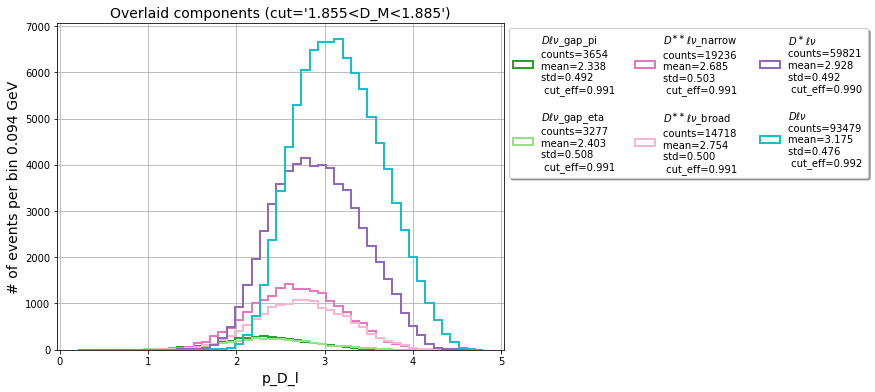

In [9]:
b1 = np.linspace(0.2,4.8,51)
mpl.plot_mc_1d_overlaid(variable='p_D_l',bins=b1,cut='1.855<D_M<1.885',mask=[],
                        show_only='norm',density=False)

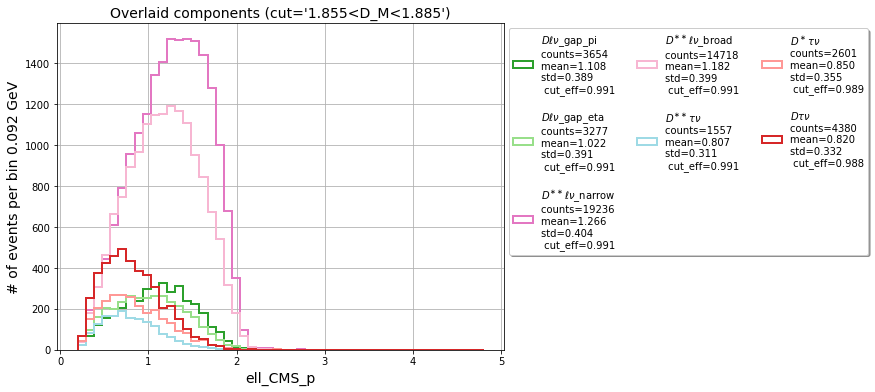

In [5]:
b1 = np.linspace(0.2,4.8,51)
mpl.plot_mc_1d_overlaid(variable='ell_CMS_p',bins=b1,mask=[],
                        cut='1.855<D_M<1.885',
                        show_only='sig',density=False)

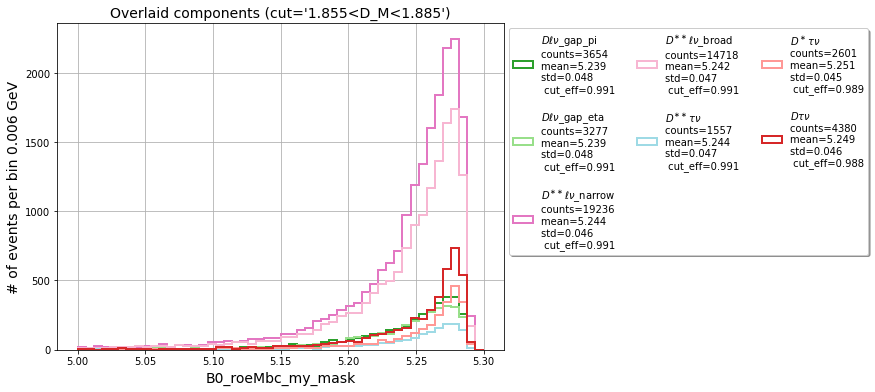

In [5]:
b1 = np.linspace(5,5.3,51)
mpl.plot_mc_1d_overlaid(variable='B0_roeMbc_my_mask',bins=b1,mask=[],
                        cut='1.855<D_M<1.885',
                        show_only='sig',density=False)

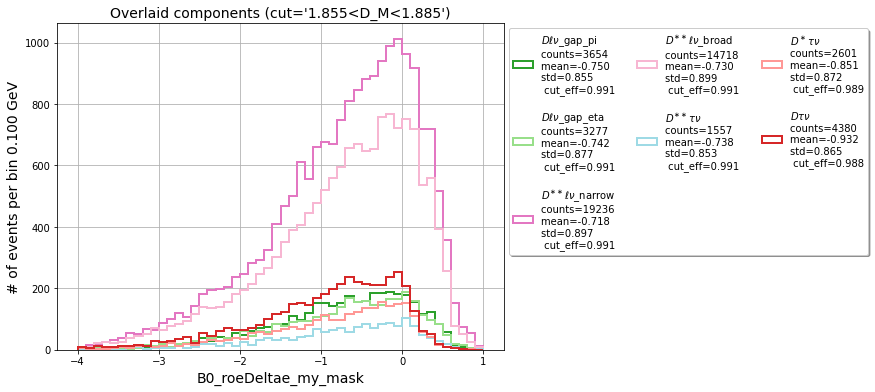

In [7]:
b1 = np.linspace(-4,1,51)
mpl.plot_mc_1d_overlaid(variable='B0_roeDeltae_my_mask',bins=b1,mask=[],
                        cut='1.855<D_M<1.885',
                        show_only='sig',density=False)

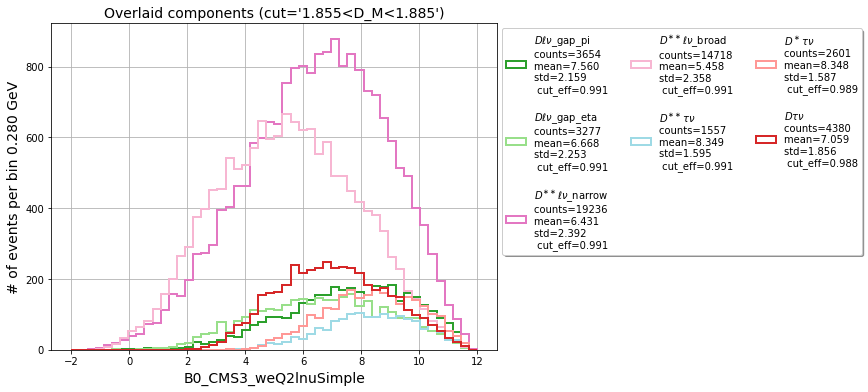

In [11]:
b1 = np.linspace(-2,12,51)
mpl.plot_mc_1d_overlaid(variable='B0_CMS3_weQ2lnuSimple',bins=b1,mask=[],
                        cut='1.855<D_M<1.885',
                        show_only='sig',density=False)

# BKG distribution at M_D sidebands, Data vs. MC

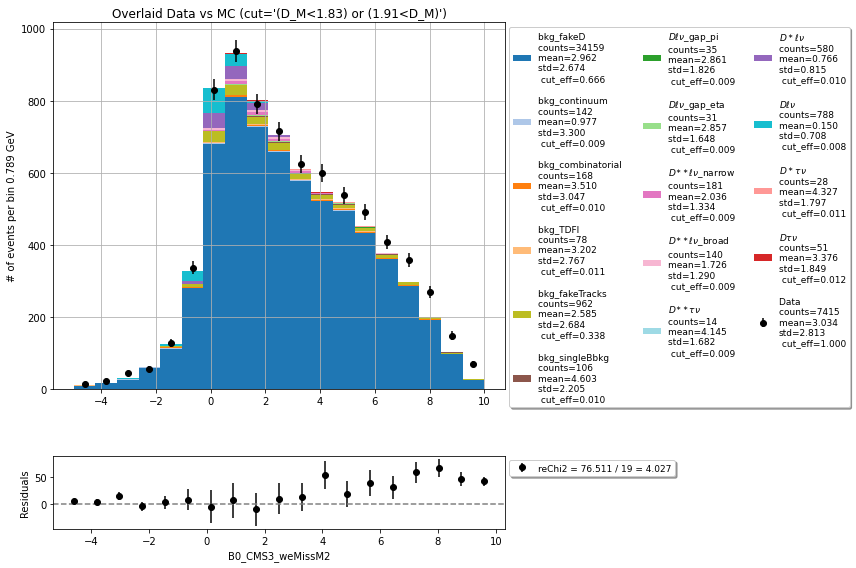

In [18]:
b1 = np.linspace(-5,10,21)
data_hist_all, mc_hist_all = mpl.plot_data_mc_stacked(
    variable='B0_CMS3_weMissM2',bins=b1,cut='(D_M<1.83) or (1.91<D_M)',scale=[1,187/1000],density=False,
    correction=False,mask=[],figsize=(12,8),ratio=False,data_sig_mask=True,
                                legend_nc=3, legend_fs=9)

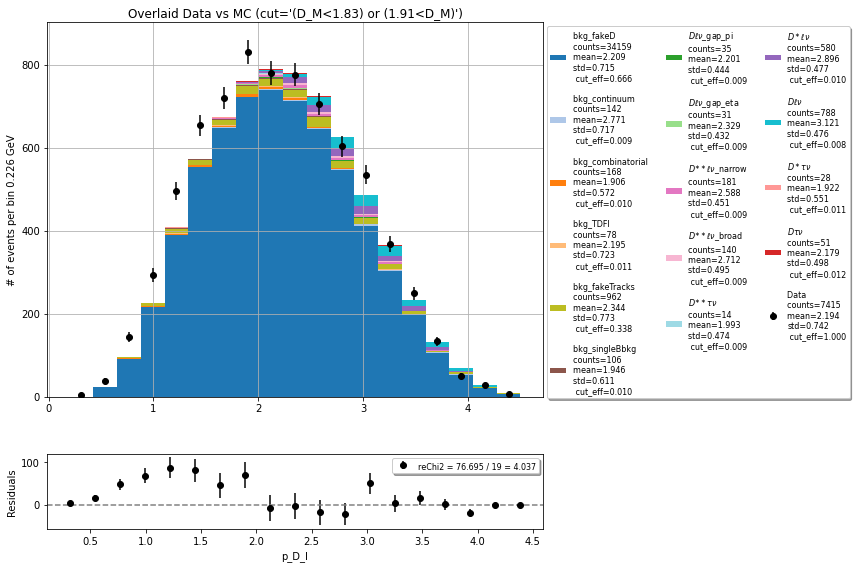

In [19]:
b1 = np.linspace(0.2,4.5,21)
data_hist_all, mc_hist_all = mpl.plot_data_mc_stacked(
    variable='p_D_l',bins=b1,cut='(D_M<1.83) or (1.91<D_M)',scale=[1,187/1000],density=False,
    correction=False,mask=[],figsize=(12,8),ratio=False,data_sig_mask=True,
                                legend_nc=3, legend_fs=8)

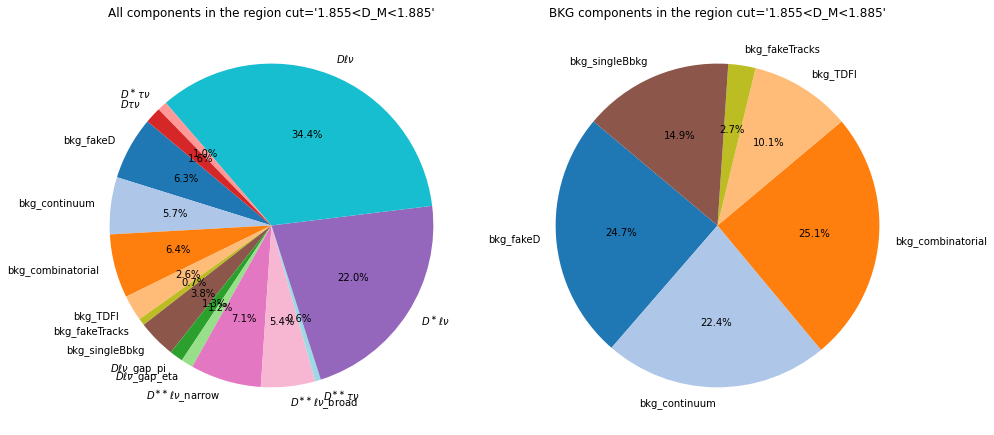

In [20]:
mpl.plot_pie()

# Create data driven template for FakeD
## 1. Calculate the sidebands to sig region scaling factors
### a. Histogram the D_M distribution

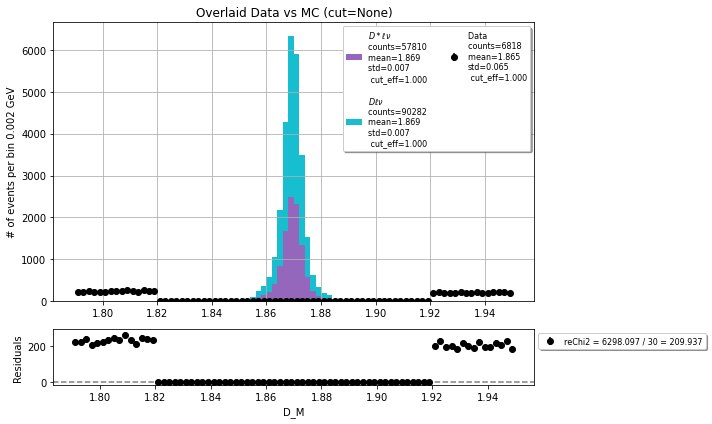

In [17]:
b1 = np.linspace(1.79,1.95,81)
data_hist_all, mc_hist_all = mpl.plot_data_mc_stacked(
    variable='D_M',bins=b1,cut=None,
    scale=[1,187/1000],correction=False,data_sig_mask=True,
    figsize=(10,6),ratio=False,legend_fs=8,legend_nc=2,
    mask=['bkg_fakeD',
        'bkg_TDFl',
        'bkg_fakeTracks',
        'bkg_continuum',
        'bkg_combinatorial',
        'bkg_singleBbkg',
        r'$D\tau\nu$',
        r'$D^\ast\tau\nu$',
#         r'$D\ell\nu$',
#         r'$D^\ast\ell\nu$',
        r'$D^{\ast\ast}\tau\nu$',
        r'$D^{\ast\ast}\ell\nu$_narrow',
        r'$D^{\ast\ast}\ell\nu$_broad',
        r'$D\ell\nu$_gap_pi',
        r'$D\ell\nu$_gap_eta',],)

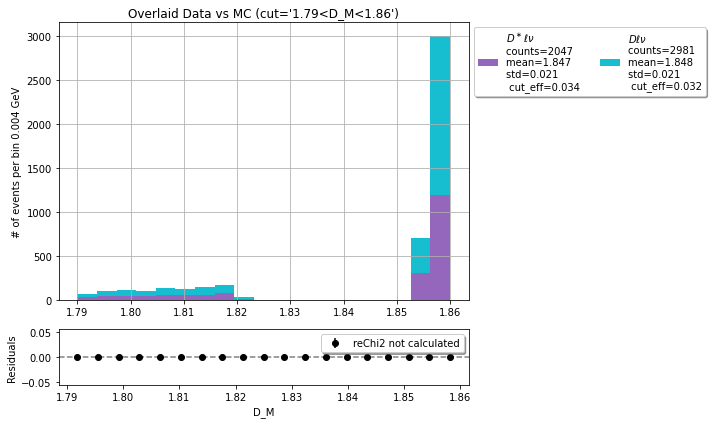

In [26]:
b1 = np.linspace(1.79,1.86,21)
data_hist_all, mc_hist_all = mpl.plot_data_mc_stacked(
    variable='D_M',bins=b1,cut='1.79<D_M<1.86',
    scale=[1,187/200],correction=False,data_sig_mask=True,
    figsize=(10,6),ratio=False,legend_fs=10,legend_nc=3,
    mask=['bkg_fakeD',
        'bkg_TDFl',
        'bkg_fakeTracks',
        'bkg_continuum',
        'bkg_combinatorial',
        'bkg_singleBbkg',
        r'$D\tau\nu$',
        r'$D^\ast\tau\nu$',
#         r'$D\ell\nu$',
#         r'$D^\ast\ell\nu$',
        r'$D^{\ast\ast}\tau\nu$',
        r'$D^{\ast\ast}\ell\nu$_narrow',
        r'$D^{\ast\ast}\ell\nu$_broad',
        r'$D\ell\nu$_gap_pi',
        r'$D\ell\nu$_gap_eta',],)

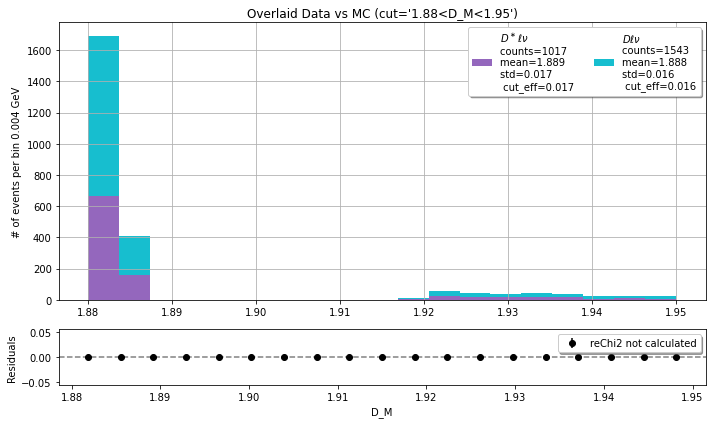

In [27]:
b1 = np.linspace(1.88,1.95,21)
data_hist_all, mc_hist_all = mpl.plot_data_mc_stacked(
    variable='D_M',bins=b1,cut='1.88<D_M<1.95',
    scale=[1,187/200],correction=False,data_sig_mask=True,
    figsize=(10,6),ratio=False,legend_fs=10,legend_nc=3,
    mask=['bkg_fakeD',
        'bkg_TDFl',
        'bkg_fakeTracks',
        'bkg_continuum',
        'bkg_combinatorial',
        'bkg_singleBbkg',
        r'$D\tau\nu$',
        r'$D^\ast\tau\nu$',
#         r'$D\ell\nu$',
#         r'$D^\ast\ell\nu$',
        r'$D^{\ast\ast}\tau\nu$',
        r'$D^{\ast\ast}\ell\nu$_narrow',
        r'$D^{\ast\ast}\ell\nu$_broad',
        r'$D\ell\nu$_gap_pi',
        r'$D\ell\nu$_gap_eta',],)

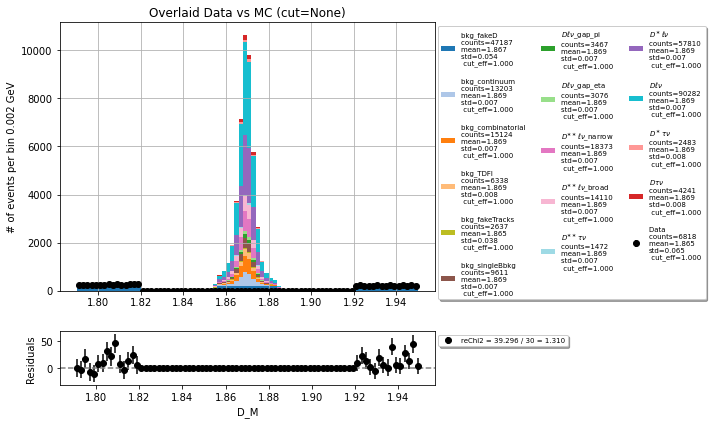

In [18]:
b1 = np.linspace(1.79,1.95,81)
data_hist_all, mc_hist_all = mpl.plot_data_mc_stacked(variable='D_M',bins=b1,cut=None,
                                                      scale=[1,187/1000],correction=False,
                                                      data_sig_mask=True,
                                                      mask=[],figsize=(10,6),ratio=False,
                                                      legend_fs=7,legend_nc=3)

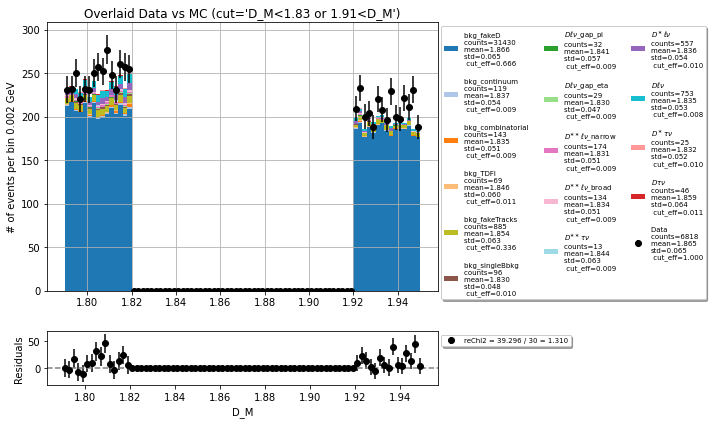

In [5]:
b1 = np.linspace(1.79,1.95,81)
data_hist_all, mc_hist_all = mpl.plot_data_mc_stacked(variable='D_M',bins=b1,cut='D_M<1.83 or 1.91<D_M',
                                                      scale=[1,187/1000],correction=False,
                                                      data_sig_mask=True,
                                                      mask=[],figsize=(10,6),ratio=False,
                                                      legend_fs=7,legend_nc=3)

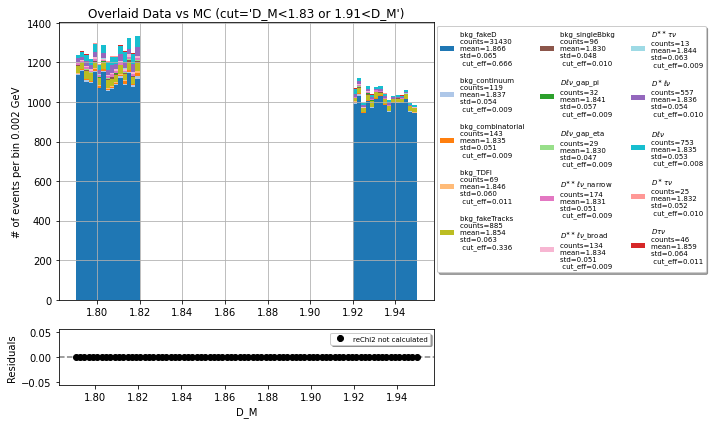

In [12]:
b1 = np.linspace(1.79,1.95,81)
data_hist_all, mc_hist_all = mpl.plot_data_mc_stacked(variable='D_M',bins=b1,cut='D_M<1.83 or 1.91<D_M',
                                                      scale=[1,1],correction=False,
                                                      data_sig_mask=True,
                                                      mask=[],figsize=(10,6),ratio=False,
                                                      legend_fs=7,legend_nc=3)

### b. fit the FakeD with a polynomial

In [13]:
fitter = util.fit_iminuit(x_edges=b1, hist=mc_hist_all, poly_only=True)

In [14]:
m_ls, c_ls, result_ls = fitter.fit_gauss_poly_LS(deg=1, loss='linear') #'soft_l1'
m_ls
# fitter.plot_poly(x=bin_edges_sb, y=data_hist_sb, yerr=data_err_sb,result=result)

initial parameters= [ 6.9000e+00  1.8600e+00  7.0000e-02 -1.6156e+03  4.1729e+03]


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 41.11 (chi2/ndof = 1.5)    │              Nfcn = 47               │
│ EDM = 1.12e-14 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │   0.00    │   0.07    │            │            │    0    │         │  yes  │
│ 1 │ x1   │   1.860   │   0.019   │            │            │    0    │         │  yes  │
│ 2 │ x2   │  70.0e-3  │  0.7e-3   │            │            │    0    │         │  yes  │
│ 3 │ x3   │  -1.62e3  │  0.09e3   │            │            │         │         │       │
│ 4 │ x4   │  4.17e3   │  0.18e3   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬───────────────────────────────────────────────────┐
│    │        x0        x1        x2        x3        x4 │
├────┼───────────────────────────────────────────────────┤
│ x0 │         0         0         0         0         0 │
│ x1 │         0         0         0         0         0 │
│ x2 │         0         0         0         0         0 │
│ x3 │         0         0         0  8.87e+03 -1.66e+04 │
│ x4 │         0         0         0 -1.66e+04  3.13e+04 │
└────┴───────────────────────────────────────────────────┘

In [15]:
m_ml, c_ml, result_ml = fitter.fit_gauss_poly_ML(deg=1)
m_ml
# fitter.plot_poly(x=bin_edges_sb, y=data_hist_sb, yerr=data_err_sb,result=result)

initial parameters= [ 3.4505e+03  1.8600e+00  7.0000e-02  3.4505e+04 -1.6156e+03  4.1729e+03]


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 41.48 (chi2/ndof = 1.5)    │              Nfcn = 186              │
│ EDM = 7.27e-08 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │     0     │    34     │            │            │    0    │         │  yes  │
│ 1 │ x1   │   1.860   │   0.019   │            │            │    0    │         │  yes  │
│ 2 │ x2   │  70.0e-3  │  0.7e-3   │            │            │    0    │         │  yes  │
│ 3 │ x3   │  92.0e3   │   0.5e3   │            │            │         │         │       │
│ 4 │ x4   │  -0.74e3  │  0.27e3   │            │            │         │         │       │
│ 5 │ x5   │   1.9e3   │   0.7e3   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬─────────────────────────────────────────────────────────────┐
│    │        x0        x1        x2        x3        x4        x5 │
├────┼─────────────────────────────────────────────────────────────┤
│ x0 │         0         0         0         0         0         0 │
│ x1 │         0         0         0         0         0         0 │
│ x2 │         0         0         0         0         0         0 │
│ x3 │         0         0         0  2.45e+05     -1.49      3.86 │
│ x4 │         0         0         0     -1.49  7.15e+04 -1.84e+05 │
│ x5 │         0         0         0      3.86 -1.84e+05  4.75e+05 │
└────┴─────────────────────────────────────────────────────────────┘

### c. Calculate the yield ratio

In [16]:
# fit poly only, LS
yields_left = fitter.poly_integral(xrange=[1.79,1.82],result=result_ls)
yields_sig = fitter.poly_integral(xrange=[1.855,1.885],result=result_ls)
yields_right = fitter.poly_integral(xrange=[1.92,1.95],result=result_ls)
print(yields_sig/yields_left, yields_sig/yields_right)

Area under polynomial from 1.79 to 1.82 = 37.664 ± 0.275
Area under polynomial from 1.855 to 1.885 = 34.512 ± 0.186
Area under polynomial from 1.92 to 1.95 = 31.361 ± 0.247
0.916+/-0.004 1.100+/-0.006


In [17]:
# fit poly only, ML
yields_left = fitter.poly_integral(xrange=[1.79,1.82],result=result_ml)
yields_sig = fitter.poly_integral(xrange=[1.855,1.885],result=result_ml)
yields_right = fitter.poly_integral(xrange=[1.92,1.95],result=result_ml)
print(yields_sig/yields_left, yields_sig/yields_right)

Yields from 1.79 to 1.82 = 18834.419 ± 136.815
Yields from 1.855 to 1.885 = 17252.524 ± 92.878
Yields from 1.92 to 1.95 = 15670.629 ± 124.718
0.916+/-0.004 1.101+/-0.006


In [29]:
a = len(samples['bkg_fakeD'].query('1.79<D_M<1.82')) #* 187/1000
b = len(samples['bkg_fakeD'].query('1.92<D_M<1.95')) #* 187/1000
c = len(samples['bkg_fakeD'].query('1.855<D_M<1.885')) #* 187/1000
print('truth of fakeD in sideband:',a,c,b, c/a, c/b)

truth of fakeD in sideband: 16616 15757 14814 0.948302840635532 1.0636560010800593


### d. Plot and compare MC of the weighted sideband and signal region

In [ ]:
# calculating the scaling factors from mc
b1 = np.linspace(-4,10,50)
b2 = np.linspace(0.3,4.5,50)
scale = {'left sideband': yields_sig/yields_left/2,
         'signal region': 1,
         'right sideband': yields_sig/yields_right/2}
mpl.plot_mc_sig_control(variable=['B0_CMS3_weMissM2','p_D_l'],
                        bins=[b1,b2],
                        bkg_name='bkg_fakeD',cut=None,merge_sidebands=True,
                        scale=scale,correction=False,mask=[],figsize=(16,5))

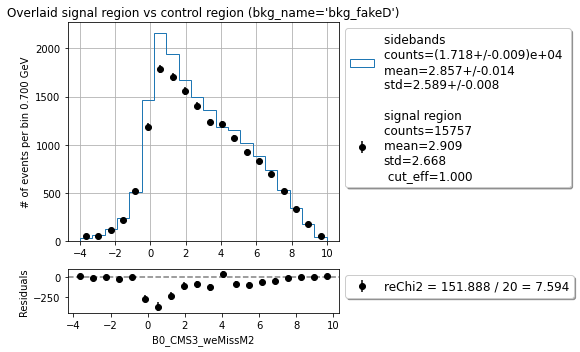

In [30]:
# calculating the scaling factors from mc
b1 = np.linspace(-4,10,21)
scale = {'left sideband': (yields_sig/yields_left/2).n,
         'signal region': 1,
         'right sideband': (yields_sig/yields_right/2).n}
mpl.plot_mc_sig_control(variable='B0_CMS3_weMissM2',bins=b1,
                        bkg_name='bkg_fakeD',cut=None,merge_sidebands=True,
                        scale=scale,correction=False,mask=[],
                        legend_fs=12,legend_nc=1)

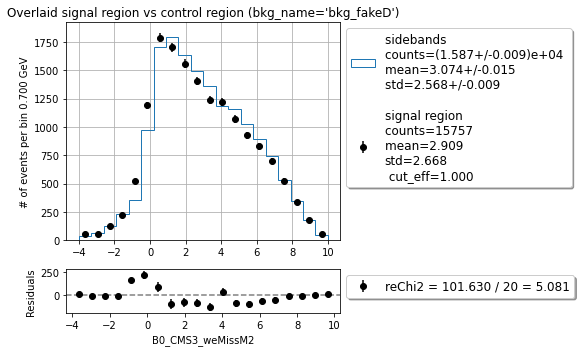

In [33]:
# calculating the scaling factors from mc
b1 = np.linspace(-4,10,21)
scale = {'left sideband': (yields_sig/yields_left/2).n,
         'signal region': 1,
         'right sideband': (yields_sig/yields_right/2).n}
mpl.plot_mc_sig_control(variable='B0_CMS3_weMissM2',bins=b1,
                        bkg_name='bkg_fakeD',cut=None,merge_sidebands=True,
                        scale=scale,correction=False,mask=[],
                        legend_fs=12,legend_nc=1)

# Signal MC

In [14]:
# 4S Data vs MC

cut = '(5<B0_roeMbc_my_mask) & (-4<B0_roeDeltae_my_mask) & (B0_roeDeltae_my_mask<1)'

# Load data files
MC_sig = uproot.concatenate([f'../../Samples/Generic_MC15ri/e_channel/MC15ri_sig_quaxo_e_1/*.root:B0'],
                          library="np",
                          cut = cut,
                          filter_branch=lambda branch: branch.name in columns)

df_mc_sig = pd.DataFrame(MC_sig)

In [15]:
lgb_tight = 'sig_prob==largest_prob and sig_prob>0.6 and fakeD_prob<0.05'
ag_tight = 'sig_prob==largest_prob and sig_prob>0.8 and fakeD_prob<0.05'
MVA_all = 'D_M>0'

df_mc_sig.eval('B_D_ReChi2 = B0_vtxReChi2 + D_vtxReChi2', inplace=True)
df_mc_sig.eval('p_D_l = D_CMS_p + ell_CMS_p', inplace=True)

df_mc_sig_lgb = util.apply_mva_bcs(df_mc_sig, training_variables, lgb_tight, library='lgbm')

In [16]:
samples=util.get_dataframe_samples_new(df_mc_sig_lgb, 'e', template=False)
mpl=util.mpl(samples)
for name, df in samples.items():
    print(name, len(df))

bkg_fakeD 21978
bkg_TDFl 1998
bkg_fakeTracks 1456
bkg_continuum 0
bkg_combinatorial 13430
bkg_singleBbkg 2793
bkg_other_TDTl 0
$D\tau\nu$ 19505
$D^\ast\tau\nu$ 10179
$D\ell\nu$ 32183
$D^\ast\ell\nu$ 20601
$D^{\ast\ast}\tau\nu$ 18450
$D^{\ast\ast}\ell\nu$_narrow 6048
$D^{\ast\ast}\ell\nu$_broad 4185
$D\ell\nu$_gap_pi 1281
$D\ell\nu$_gap_eta 1458
bkg_other_signal 0


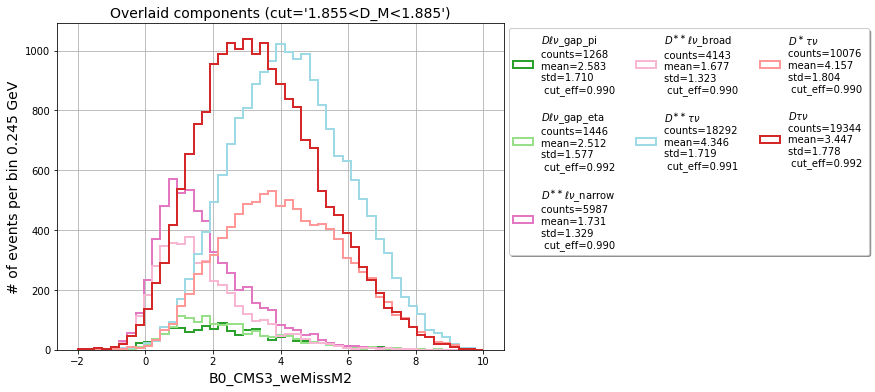

In [17]:
b1 = np.linspace(-2,10,51)
mpl.plot_mc_1d_overlaid(variable='B0_CMS3_weMissM2',bins=b1,mask=[],
                        cut='1.855<D_M<1.885',
                        show_only='sig',density=False)

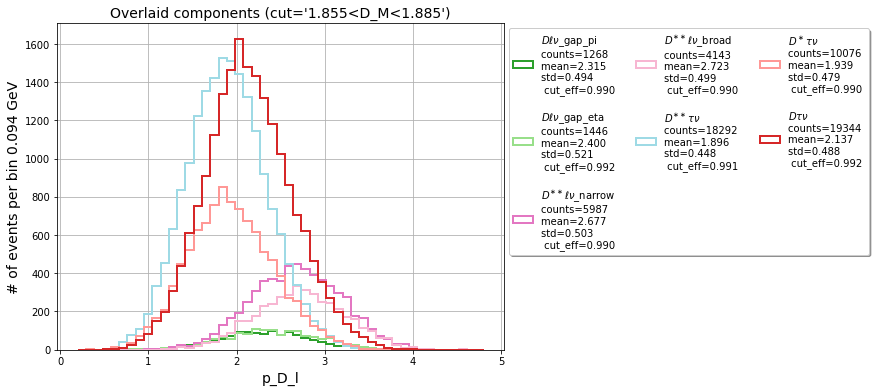

In [25]:
b1 = np.linspace(0.2,4.8,51)
mpl.plot_mc_1d_overlaid(variable='p_D_l',bins=b1,mask=[],
                        cut='1.855<D_M<1.885',
                        show_only='sig',density=False)

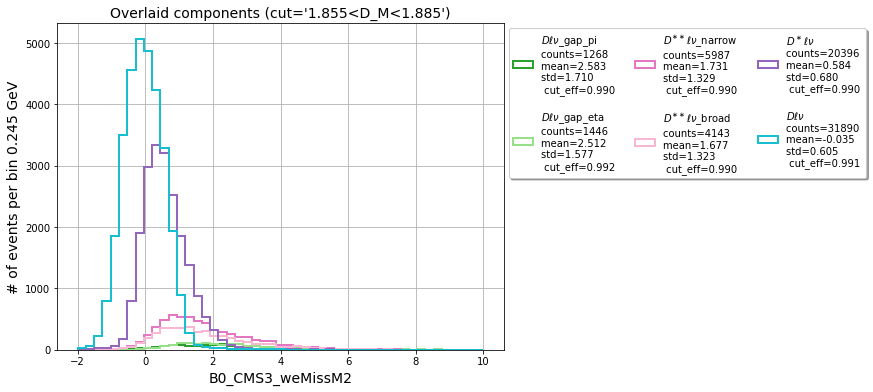

In [20]:
b1 = np.linspace(-2,10,51)
mpl.plot_mc_1d_overlaid(variable='B0_CMS3_weMissM2',bins=b1,
                        cut='1.855<D_M<1.885',mask=[],
                        show_only='norm',density=False)

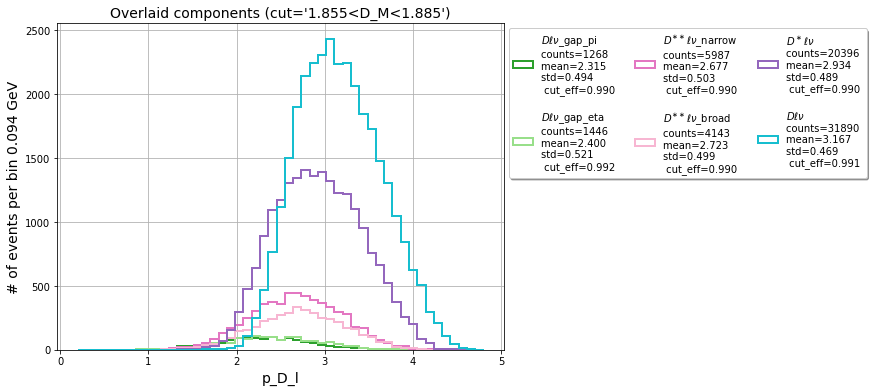

In [24]:
b1 = np.linspace(0.2,4.8,51)
mpl.plot_mc_1d_overlaid(variable='p_D_l',bins=b1,cut='1.855<D_M<1.885',mask=[],
                        show_only='norm',density=False)

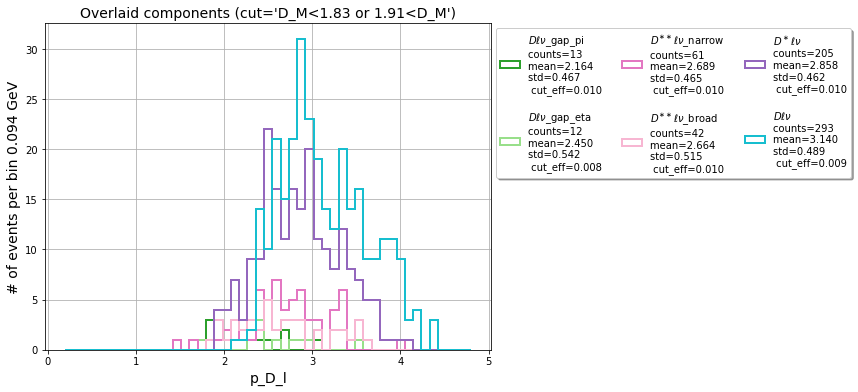

In [26]:
b1 = np.linspace(0.2,4.8,51)
mpl.plot_mc_1d_overlaid(variable='p_D_l',bins=b1,cut='D_M<1.83 or 1.91<D_M',mask=[],
                        show_only='norm',density=False)